In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# データを分割して最大値と最小値を求め、データのスケール変換を行い、SVMを訓練する
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print(f"Test score: {svm.score(X_test_scaled, y_test):.2f}")

Test score: 0.97


<h1>前処理を行う際のパラメータ選択</h1>

In [3]:
# 交差検証において、訓練データとテストデータに分割する前の全データに対してスケール変換（前処理）を行っているため、
# テストデータになるべき部分の情報がモデル構築過程にリークしてしまっている
# 従って、前処理をする前に交差検証のためのデータ分割を行う必要がある
from sklearn.model_selection import GridSearchCV

param_grid = {"C":[0.001, 0.01, 0.1, 1, 10, 100],"gamma":[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid = param_grid, cv = 5)
grid.fit(X_train_scaled, y_train)
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
print(f"Best set score: {grid.score(X_test_scaled, y_test):.2f}")
print("Best parmeters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parmeters:  {'C': 1, 'gamma': 1}


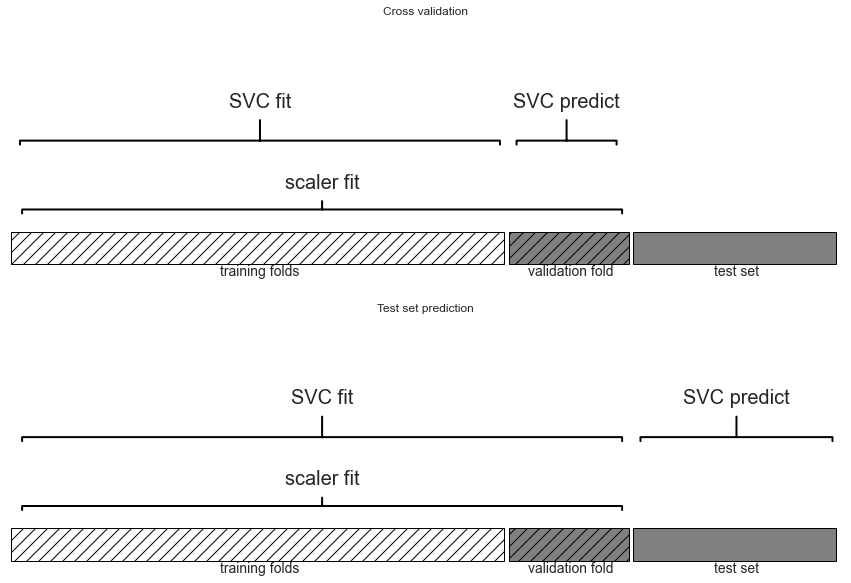

In [4]:
import mglearn

mglearn.plots.plot_improper_processing()

<h1>パイプラインの構築</h1>

In [5]:
# pipe.fitはまず、第一ステップ（scaler）のfitを呼び出して訓練データをscalerを用いて変換し、次にSVMを、変換されたデータを用いてfitする
# テストデータを用いて評価するには、pipe.scoreを用いればよい
# パイプラインのscoreメソッドを呼ぶと、まずテストデータをscalerで変換し、SVMのscoreメソッドを変換されたデータで呼び出す
# パイプラインを用いると、「前処理+クラス分類」プロセスに必要なコード量を減らすことができる
# パイプラインの真価は、cross_val_scoreやGridSearchCVにおいて、パイプラインを単独のEstimatorとして用いることができる点にある
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])
pipe.fit(X_train, y_train)
print(f"Test score: {pipe.score(X_test, y_test):.2f}")

Test score: 0.97


<h1>パイプラインを用いたグリッドサーチ</h1>

In [6]:
# パラメータに対してパラメータグリッドを定義する文法は、個々のパラメータを、ステップの前に__を続け、その後ろにパラメータ名を書いて指定する

param_grid = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100],"svm__gamma":[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f"Best cross-validation accuracy: {grid.best_score_}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_params_}")

Best cross-validation accuracy: 0.9812311901504789
Test set score: 0.97
Best cross-validation accuracy: {'svm__C': 1, 'svm__gamma': 1}


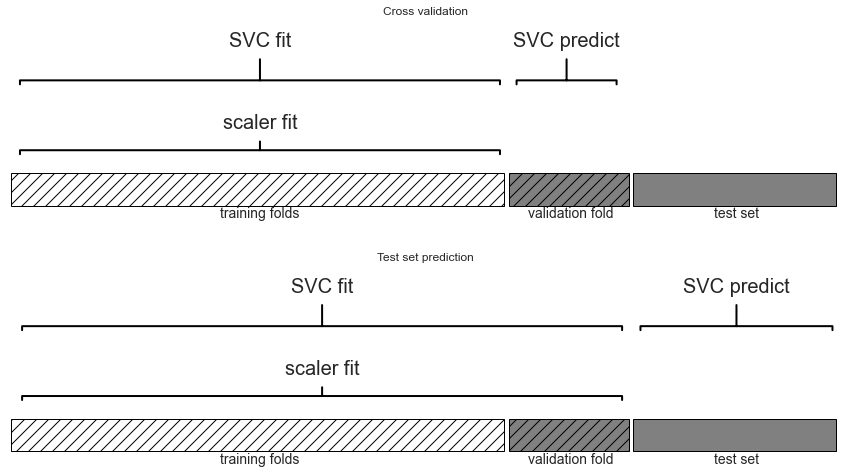

In [7]:
mglearn.plots.plot_proper_processing()

<h1>汎用パイプラインインターフェイス</h1>

In [8]:
# Pipeline.fitが呼び出されると、各ステップに対して前段のステップのtransformメソッドの出力を入力として、fitを呼び出してからtransformを呼び出す
# パイプラインの最後のステップではfitだけが呼ばれる
# Pipelineを用いて予測を行う際には、同様に最後のステップ以外でデータに対してtransformを行い、最後のステップではpredictを呼び出す
# パイプラインに並べるEstimatorに関する制約は、最後以外のステップには次のステップで使うデータの新しい表現を生成するために、
# transformメソッドが定義されている必要があるということだけだ

# Pipeline.fitの話
# パイプラインの最後のステップにpredictメソッドがなくても構わないので、例えばスケール変換器とPCAだけを持つようなパイプラインを作ることもできる
# この場合、最後のステップ（PCA）にtransformメソッドがあるので、パイプラインに対してtransformメソッドを呼び出して、
# スケール変換されたデータに対してPCA,transformを行った結果を得ることができる
# パイプラインの最後のステップに対する要求は、fitメソッドを持つことだけだ

# pipeline.stepsはタプルのリストなので、pipeline.steps[0][1]が最初のEstimator、pipeline.steps[1][1]が2番目のEstimator、というようになっている
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_trasform(X_transformed, y)
    
    self.steps[-1][1].fit(X_transformed, y)
    return self

def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    
    return self.steps[-1][1].predict(X_transformed)

<h4>make_pipelineによる簡便なパイプライン生成</h4>

In [9]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C = 100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C = 100))
print(f"Pipeline steps:\n{pipe_short.steps}")

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print(f"Pipeline steps:\n{pipe.steps}")

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


<h4>ステップ属性へのアクセス</h4>

In [11]:
# パイプラインの各ステップにアクセスする最も簡単な方法は、named_steps属性を使う方法だ。これは、ステップ名とEstimatorのディクショナリである

pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print(f"components.shape: {components.shape}")

components.shape: (2, 30)


<h4>GridSearchCV内のパイプラインの属性へのアクセス</h4>

In [12]:
# 訓練データに対して訓練を行って見つけた最良のモデルは、grid.best_estimator_に格納されている
# この場合、best_estimator_には、standardscalerとlogisticregressionの2ステップからなるパイプラインが格納されている
# logisticregressionにアクセスするには、上で説明したようにパイプラインのnamed_steps属性を用いる
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 10000))
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 4)
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f"Best estimator:\n{grid.best_estimator_}")
print(f"Logistic regression step:\n{grid.best_estimator_.named_steps['logisticregression']}")
print(f"Logistic regression coefficients:\n{grid.best_estimator_.named_steps['logisticregression'].coef_}")

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=10000))])
Logistic regression step:
LogisticRegression(C=1, max_iter=10000)
Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


<h1>前処理ステップとモデルパラメータに対するグリッドサーチ</h1>

In [13]:
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

In [14]:
# 回帰やクラス分類などの教師あり学習タスクの結果を使って、前処理のパラメータの調整を行うことができる
# 前処理のパラメータをモデルのパラメータと同時にサーチする方法は非常に強力な戦略である
# ただし、GridSearchCVは、すべてのパラメータの組合せを探索することに注意しよう
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
param_grid = {"polynomialfeatures__degree":[1,2,3], "ridge__alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


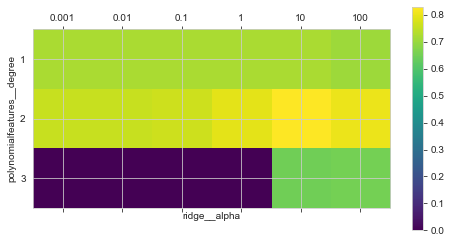

In [15]:
plt.matshow(grid.cv_results_["mean_test_score"].reshape(3, -1), vmin = 0, cmap = "viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid["ridge__alpha"])), param_grid["ridge__alpha"])
plt.yticks(range(len(param_grid["polynomialfeatures__degree"])), param_grid["polynomialfeatures__degree"])
plt.colorbar()
print(f"Best parameters: {grid.best_params_}")
print(f"Test-set score: {grid.score(X_test, y_test):.2f}")

In [16]:
param_grid = {"ridge__alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f"Score without poly features: {grid.score(X_test, y_test):.2f}")

Score without poly features: 0.63


<h1>グリッドサーチによるモデルの選択</h1>

In [17]:
# パイプラインで実際に行われるステップに対してもサーチすることが可能
# 例えば、StandardScalerとMinMaxScalerのどちらを用いるのか、SVCとRandomForestClassifierのどちらを用いるのかをサーチの対象にすることができる
# パイプライン中のステップを飛ばしたい場合（例えばRandomForestには前処理は必要ない）には、そのステップをNoneにすればよい
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([("preprocessing", StandardScaler()),("classifier", SVC())])
# 下記pipeでも上記pipeと同じ結果が得られるため、ここではclassifierにランダムフォレストを指定しなくてよく、SVC()を仮置きしているものと思われる
#pipe = Pipeline([("preprocessing", StandardScaler()),("classifier", RandomForestClassifier(n_estimators = 100))])
param_grid = [{"classifier":[SVC()], "preprocessing":[StandardScaler(), MinMaxScaler(),  None], 
               "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100], "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100]},
              {"classifier":[RandomForestClassifier(n_estimators = 100)], "preprocessing":[None],
              "classifier__max_features":[1,2,3]}]
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print(f"Best params:\n{grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Test-set score: {grid.score(X_test, y_test):.2f}")

Best params:
{'classifier': SVC(C=1), 'classifier__C': 1, 'preprocessing': MinMaxScaler()}
Best cross-validation score: 0.98
Test-set score: 0.97
